## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link
-----

### Code

In [1]:
import glob
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
from matplotlib import pyplot as plt
from utils import *

In [2]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.

    percentile90_confidence = np.percentile(confidence_est, 10)
    print(percentile90_confidence)
    
    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    print(f'errs: {len(errs)} , confs: {len(confs)}')
    return AggregateErrorMetric(errs, confs)

In [3]:
def bandpass_filter(signal, fs):
    """
    Runs a bandpass filter with butterworth algorithm.

    Returns:
        Bandpass filtered signal
    """          
    pass_band=(40/60.0, 240/60.0)
    b, a = scipy.signal.butter(5, pass_band, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)

### EDA

In [4]:
data_fls, ref_fls = LoadTroikaDataset()
val = sp.io.loadmat(data_fls[0])
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])
fs = 125

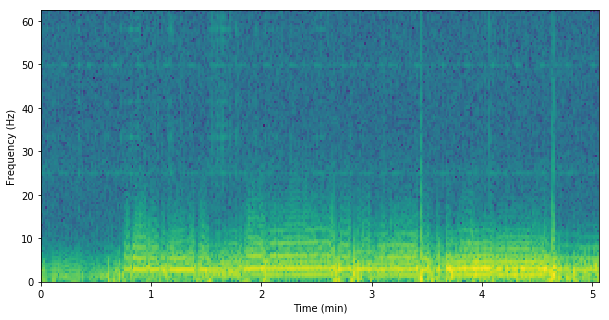

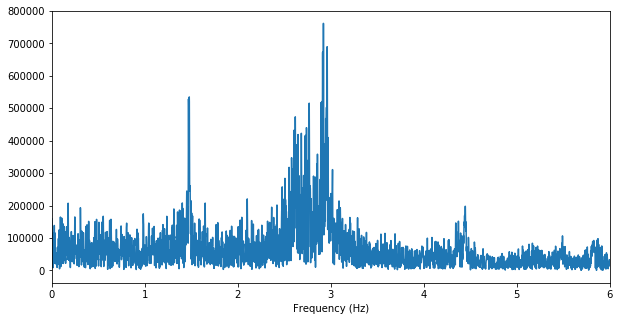

In [5]:
# Plot the spectrogram for the PPG signal
plot_specgram(ppg, fs)
plot_fft1(ppg, fs)

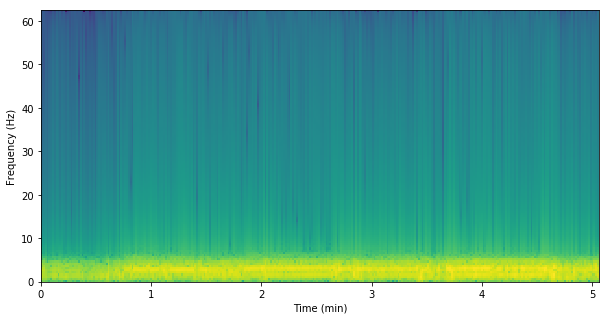

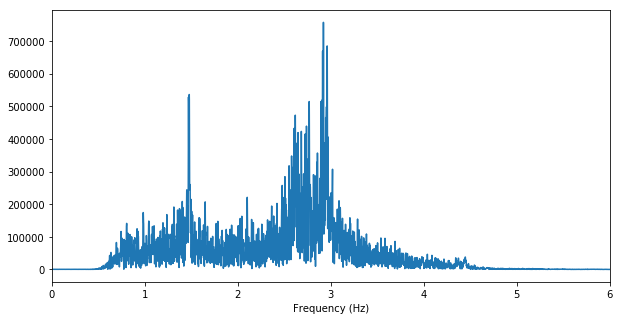

In [6]:
# Filter out the noise from the PPG signal using the bandpass filter
# Use values defined in Part 1 README.md and TroikaDataset README.pdf
fs = 125
low_freq = 40/60
high_freq = 240/60
filtered_ppg = bandpass_filter(ppg, fs)

plot_specgram(filtered_ppg, fs)
plot_fft1(filtered_ppg, fs)

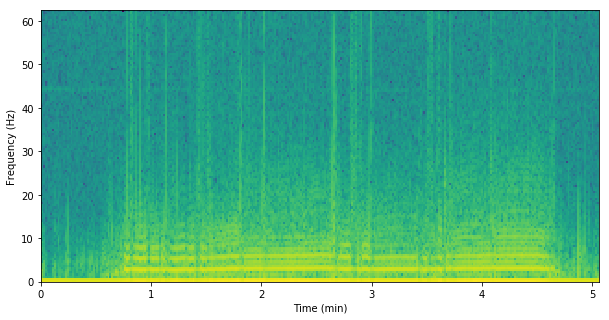

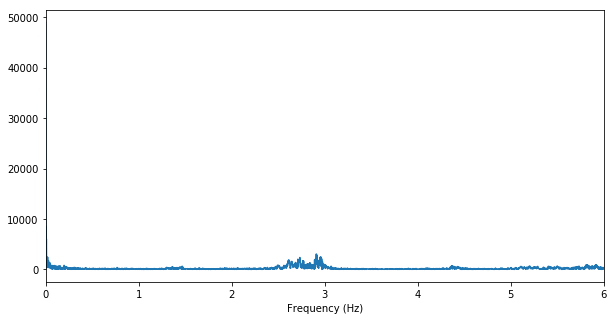

In [7]:
# Plot the spectrogram for the ACC signal
acc = np.sqrt(accx**2 + accy**2 + accz**2)

plot_specgram(acc, fs)
plot_fft1(acc, fs)

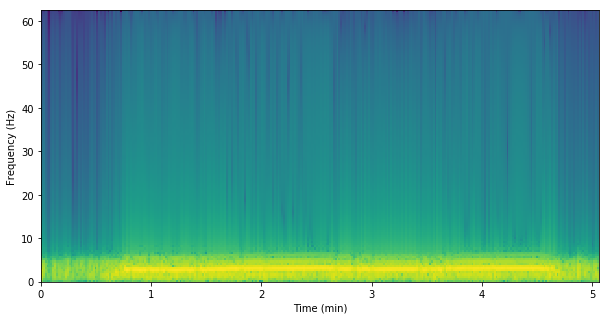

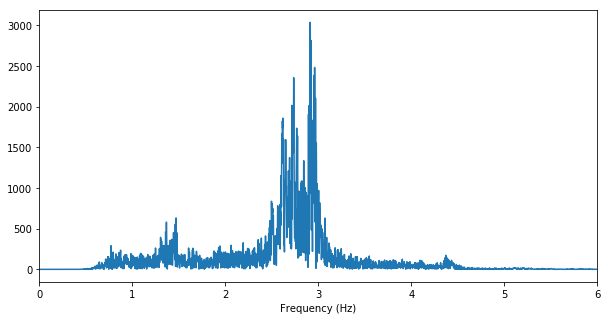

In [8]:
# Filter out the noise from the ACC signal using the bandpass filter
filtered_acc = bandpass_filter(acc, fs)
plot_specgram(filtered_acc, fs)
plot_fft1(filtered_acc, fs)

### Algorithm

In [9]:
def get_features(ppg, acc, fs):
    """
    Get features in our data
    
    Returns:
        PPG and ACC: Peaks, Peaks Freqency, Frequency and Magnitude after running FFT
    """
    # Fourier Transform the ppg signal
    ppg_freqs, ppg_fft = fourier_transform(ppg, fs)
    
    # Filter data
    ppg_fft[ppg_freqs <= 70/60.0] = 0.0
    ppg_fft[ppg_freqs >= 190/60.0] = 0.0
    
    # Find peaks
    ppg_peaks = sp.signal.find_peaks(ppg_fft, height=2000)[0]
    ppg_peaks_f = ppg_freqs[ppg_peaks]
    
    # Fourier Transform the acc signal
    acc_freqs, acc_fft = fourier_transform(acc, fs)
    
    # Filter data
    acc_fft[acc_freqs <= 70/60.0] = 0.0
    acc_fft[acc_freqs >= 190/60.0] = 0.0
    
    # Find peaks
    acc_peaks = sp.signal.find_peaks(acc_fft, height=None)[0]
    acc_peaks_f = acc_freqs[acc_peaks]
    
    return {'ppg': (ppg_peaks, ppg_peaks_f, ppg_freqs, ppg_fft), 'acc': (acc_peaks, acc_peaks_f, acc_freqs, acc_fft)}

In [10]:
def calculate_confidence(freqs, fft_mag, bpm_f):
    """
    Calculate the confidence of the heart rate
    
    Returns:
        Confidence of the estimated heart rate
    """
    window_f = 30/60

    fundamental_freq_window = (freqs > bpm_f - window_f) & (freqs < bpm_f + window_f)
    return np.sum(fft_mag[fundamental_freq_window])/ np.sum(fft_mag)

In [11]:
def estimate(ppg, acc, window_length_s, window_shift_s, fs):
    """
    Estimate the heart rate
    
    Returns:
        The estimated heart rate and the confidence
    """
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    
    est_bpm = []
    confidence = []
    
    prev_est = 40/60
   
    for i in range(0, len(ppg) - window_length, window_shift):
        ppg_window = ppg[i:i+window_length]
        acc_window = acc[i:i+window_length]
        
        window_features = get_features(ppg_window, acc_window, fs)
        ppg_peaks, ppg_peaks_f, ppg_freqs, ppg_fft = window_features['ppg']
        acc_peaks, acc_peaks_f, acc_freqs, acc_fft = window_features['acc']
        
        ppg_max = ppg_freqs[np.argmax(ppg_fft)]
        acc_max = acc_freqs[np.argmax(acc_fft)]
        
        k = 1
        
        while np.abs(acc_max-ppg_max) <= 0.2 and k <=2:
            k+=1
            ppg_max = ppg_freqs[np.argsort(ppg_fft, axis=0)[-k]]
            acc_max = acc_freqs[np.argsort(acc_fft, axis=0)[-k]]
        
        est_bpm_f = ppg_max
        
        prev_est = est_bpm_f
        est_bpm.append(est_bpm_f*60)
        confidence.append(calculate_confidence(ppg_freqs, ppg_fft, est_bpm_f))

    return est_bpm, confidence

In [12]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    bpm = sp.io.loadmat(ref_fl)['BPM0']
    
    # Our data is sampled at 125Hz
    fs = 125
    
    # Bandpass Filter
    ppg = bandpass_filter(ppg, fs)
    accx = bandpass_filter(accx, fs)
    accy = bandpass_filter(accy, fs)
    accz = bandpass_filter(accz, fs)
    
    # Calculate the magnitute of the accelerometers
    acc = np.sqrt(accx**2 + accy**2 + accz**2)
    
    # Windowing our ppg and acc signal to estimate
    window_length_s = 8
    window_shift_s = 2    
    
    # Compute pulse rate estimates and estimation confidence.
    est_bpm, confidence = estimate(ppg, acc, window_length_s, window_shift_s, fs)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors = np.abs(np.diag(np.subtract(bpm, est_bpm)))
    
    return errors, confidence

### Testing

In [13]:
data_fls, ref_fls = LoadTroikaDataset()
num = 1
data_fl, ref_fl = data_fls[num], ref_fls[num]
errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)

In [14]:
data_fls, ref_fls = LoadTroikaDataset()
num = 0
data_fl, ref_fl = data_fls[num], ref_fls[num]
bpm = sp.io.loadmat(ref_fl)['BPM0']
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
ppg = bandpass_filter(ppg, fs)
accx = bandpass_filter(accx, fs)
accy = bandpass_filter(accy, fs)
accz = bandpass_filter(accz, fs)
acc = np.sqrt(accx**2 + accy**2 + accz**2)

In [15]:
window_length_s = 8
window_shift_s = 2  
window_length = window_length_s * fs
window_shift = window_shift_s * fs
x = [i for i in range(0, len(ppg)-window_length, window_shift)]

In [16]:
n=30
print(x[n] , x[n]+window_length)
ppg_window = ppg[x[n] : x[n]+window_length]
acc_window = acc[x[n] : x[n]+window_length]

7500 8500


In [17]:
ppg_freqs, ppg_fft = fourier_transform(ppg_window, fs)

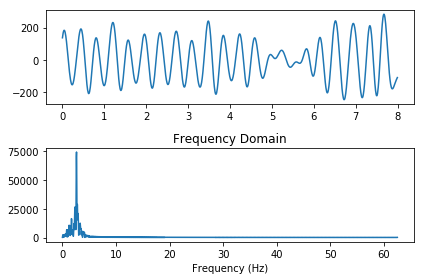

In [18]:
plot_fft2(ppg_window, ppg_freqs, ppg_fft, fs)

In [19]:
acc_freqs, acc_fft = fourier_transform(acc_window, fs)

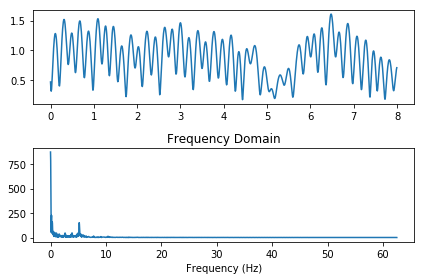

In [20]:
plot_fft2(acc_window, acc_freqs, acc_fft, fs)

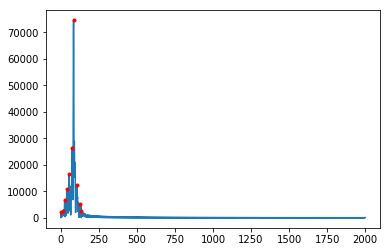

In [21]:
ppg_peaks = sp.signal.find_peaks(ppg_fft, height=2000, distance=10)[0]
plt.plot(ppg_fft)
plt.plot(ppg_peaks, ppg_fft[ppg_peaks], 'r.')

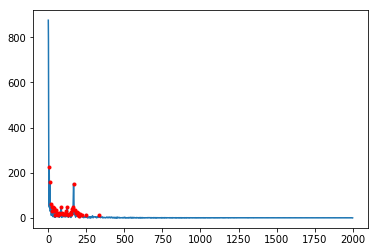

In [22]:
acc_peaks = sp.signal.find_peaks(acc_fft, height=10)[0]
plt.plot(acc_fft)
plt.plot(acc_peaks, acc_fft[acc_peaks], 'r.')

In [23]:
ppg_peaks

array([  2,  14,  26,  40,  54,  74,  84, 106, 126, 136])

In [24]:
ppg_freqs[ppg_peaks]

array([ 0.0625,  0.4375,  0.8125,  1.25  ,  1.6875,  2.3125,  2.625 ,
        3.3125,  3.9375,  4.25  ])

In [25]:
ppg_freqs[np.argmax(ppg_fft)]

2.625

In [26]:
acc_peaks

array([  6,  10,  17,  22,  26,  30,  35,  38,  42,  50,  55,  62,  66,
        70,  75,  84,  90,  94,  99, 103, 110, 114, 119, 124, 132, 137,
       141, 146, 151, 155, 160, 166, 171, 176, 184, 187, 192, 197, 201,
       206, 220, 249, 332])

In [27]:
acc_freqs[acc_peaks]

array([  0.1875 ,   0.3125 ,   0.53125,   0.6875 ,   0.8125 ,   0.9375 ,
         1.09375,   1.1875 ,   1.3125 ,   1.5625 ,   1.71875,   1.9375 ,
         2.0625 ,   2.1875 ,   2.34375,   2.625  ,   2.8125 ,   2.9375 ,
         3.09375,   3.21875,   3.4375 ,   3.5625 ,   3.71875,   3.875  ,
         4.125  ,   4.28125,   4.40625,   4.5625 ,   4.71875,   4.84375,
         5.     ,   5.1875 ,   5.34375,   5.5    ,   5.75   ,   5.84375,
         6.     ,   6.15625,   6.28125,   6.4375 ,   6.875  ,   7.78125,
        10.375  ])

In [28]:
accx_window = accx[x[n] : x[n]+window_length]
accy_window = accy[x[n] : x[n]+window_length]
accz_window = accz[x[n] : x[n]+window_length]

In [29]:
accx_freqs, accx_fft = fourier_transform(accx_window, fs)
accy_freqs, accy_fft = fourier_transform(accy_window, fs)
accz_freqs, accz_fft = fourier_transform(accz_window, fs)

[ 0.59375  0.75     0.96875  1.125    1.28125  1.5      1.71875  1.90625
  2.3125   2.65625  2.90625  3.09375  3.21875  3.46875  3.65625  3.84375]


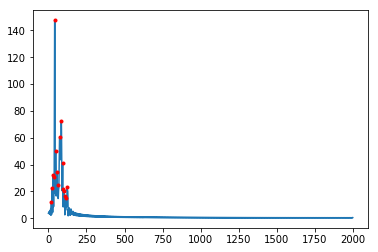

In [30]:
accx_peaks = sp.signal.find_peaks(accx_fft, height=10)[0]
plt.plot(accx_fft)
plt.plot(accx_peaks, accx_fft[accx_peaks], 'r.')
print(accx_freqs[accx_peaks])

[ 0.5      0.625    0.8125   1.       1.25     1.40625  1.53125  1.6875
  1.8125   1.90625  2.09375  2.28125  2.40625  2.59375  2.75     2.90625
  3.15625  3.28125  3.4375   3.5625   3.65625  3.84375  4.09375  4.28125
  5.15625]


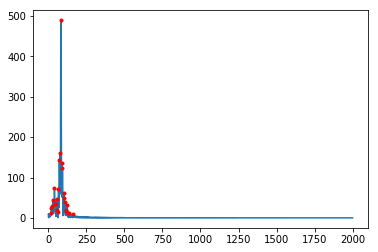

In [31]:
accy_peaks = sp.signal.find_peaks(accy_fft, height=10)[0]
plt.plot(accy_fft)
plt.plot(accy_peaks, accy_fft[accy_peaks], 'r.')
print(accy_freqs[accy_peaks])

[ 0.0625   0.21875  0.34375  0.46875  0.59375  0.78125  0.9375   1.09375
  1.28125  1.5      1.625    1.78125  2.       2.1875   2.28125  2.59375
  2.8125   3.       3.21875  3.375    3.53125  3.71875  3.90625]


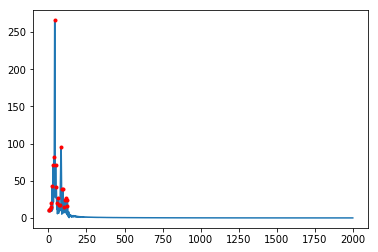

In [32]:
accz_peaks = sp.signal.find_peaks(accz_fft, height=10)[0]
plt.plot(accz_fft)
plt.plot(accz_peaks, accz_fft[accz_peaks], 'r.')
print(accz_freqs[accz_peaks])

## PROJECT DESCRIPTION

### CODE DESCRIPTION

* To run the result of the project, use the Evaluate() function.

* The Evaluate() function will handle the following steps:
    * Load the TROIKA data and reference files.
    * Run the PulseRate algorithm to estimate the heart rate
    * The RunPulseRate function will return estimated heart rates and their corresponding confidence
> Within the algorithm pipeline, it runs through four steps:
        * Filters noise from PPG and ACC signals.
        * Trains the heuristic to identify key features.
        * Predicts an estimated pulse rate.
        * Computes absolute errors and confidence.

### DATA DESCRIPTION

Two-channel PPG signals, three-axis acceleration signals, and one-channel ECG signals were simultaneously recorded from subjects with age from 18 to 35. For each subject, the PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm) and the acceleration signal was also recorded from the wrist by a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband. The ECG signal was recorded simultaneiously from the chest using wet ECG sensors. All signals were sampled at 125 Hz.

Each dataset with a similar name 'DATA_01_TYPE01' contains a variable 'sig' with 6 rows: ECG, PPG channel one, PPG channel two, ACC x-channel, ACC y-channel, and ACC z-channel. During data recording, each subject ran on a treadmill with changing speeds. The ground-truth heart rate can be calcualted from the ECG signal, but it is also stored in a dataset with a corresponding name 'REF_01_TYPE01'. A variable 'BPMO' gives the BPM value in every 8-second window, with successive windows overlaping by 6 seconds.

There are some limitations with this dataset. First, the subjects were aged 18-35, so the algorithm may not work properly with children or older adults. Second, there is no information on gender, race and health conditions. Finally, and most importantly, there were only 12 subjects in this dataset, which limits the ability to improve the algorithm. 

### ALGORITHM DESCRIPTION
#### How the algorithm works:
1. **Load Dataset**. *LoadTroikaDataset* retrieves file names from the Troika dataset (see Data Description for details), while *LoadTroikaDataFile* loads and extracts signals from the files.
2. **Run Algorithm**. *RunPulseRateAlgorithm* runs the algorithm pipeline, which consists of four steps:<br>
    (a) **Filter Noise.** *BandpassFilter* applies a bandpass filter to PPG signal and all ACC channel signals. Filter range has been defined as 40bpm to 240bpm, to correspond with reasonable physiological limits to pulse rates.<br>
    (b) **Train Heuristic.** The heuristic was trained on 8 second windows with 6 second overlaps, which matches the reference pulse rates present in the dataset. Features were extracted via the *get_features* function which calculates the fast fourier transforms of the PPG and ACC signals (transforming them into spectral space), and then finds the peak frequency components using the SCIPY find_peaks function. Peaks were then sorted according to magnitude. <br>
    (c) **Predict Pulse Rate.** The best pulse rate is found by identifying the strongest PPG peak which does not overlap with any of the ACC channel peaks. As a final check on this estimate, *RunPulseRateAlgorithm* uses the estimate from the previous window if errors are too high with respect to reference pulse rates. <br>
    (d) **Compute Errors and Confidence.** Finally, *RunPulseRateAlgorithm* calculates absolute errors with respect to the reference pulse rate, and calculate_confidence determines confidence based on the ratio of signal power around the pulse rate estimate to total power.<br>
3. **Evaluate Algorithm.** Evaluate runs the pulse rate algorithm on the Troika dataset and returns MAE at 90% availability (the best 90% of the estimates are above the 10th percentile confidence). Higher confidence means a better estimate. 

### ALGORITHM PERFORMANCE

Algorithm performance was computed using a train-test split. The TROIKA dataset, consisting of 12 files, was used for training, while another dataset of similar size was used for testing. Performance was optimized to minimize the mean absolute error (MAE) at 90% availability (based on the ratio of signal power around the pulse rate estimate to the total signal power).